# NeuroSYS - data science assignment

**Author:** Łukasz Sus

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Load received SQLite file: database.db.

In [2]:
conn = sqlite3.connect("database.db")

Get all tables names

In [3]:
cur = conn.cursor()
for row in cur.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('data',)
('connection',)
('additional_data',)


Explore tables content

In [4]:
df_data = pd.read_sql_query("SELECT * FROM data;", conn)
df_data.head()

,id,x,y,z,connection_id
0,1,44.628947,97.81099110033537,569.700453,105
1,2,40.764309,82.0486367746882,653.904064,76
2,3,25.849509,63.29510234435348,374.171176,72
3,4,18.973396,50.59596955801666,440.976635,239
4,5,44.787622,39.347747208411256,219.388963,152


In [5]:
df_connection = pd.read_sql_query("SELECT * FROM connection;", conn)
df_connection.head()

,id,name
0,2,blue
1,4,blue
2,9,blue
3,10,blue
4,15,blue


In [6]:
df_additional = pd.read_sql_query("SELECT * FROM additional_data;", conn)
df_additional.head()

,color_id,color_name
0,0,red
1,2,blue
2,3,yellow
3,4,orange
4,5,black


2. The database.db file contains several tables. Use them to create Pandas DataFrame with x, y, z, color_id and color_name for every record.

In [7]:
df_main = pd.read_sql_query("SELECT x, y, z, color_id, color_name "
                           + "FROM data "
                           + "JOIN connection ON data.connection_id=connection.id "
                           + "JOIN additional_data ON connection.name=additional_data.color_name;", conn)
df_main

,x,y,z,color_id,color_name
0,44.628947,97.81099110033537,569.700453,11,green
1,40.764309,82.0486367746882,653.904064,4,orange
2,25.849509,63.29510234435348,374.171176,4,orange
3,18.973396,50.59596955801666,440.976635,3,yellow
4,44.787622,39.347747208411256,219.388963,0,red
...,...,...,...,...,...
101195,1.851515,84.17753890986283,409.281547,5,black
101196,96.653658,89.89605659969567,172.548292,0,red
101197,21.920406,2.6404943806156767,176.266498,4,orange
101198,61.397586,65.83007246642215,300.539567,4,orange


3. Note, that x, y, z should be converted to floating-point format (if necessary), and color_id to integers.

In [8]:
df_main.dtypes

x             float64
y              object
z             float64
color_id        int64
color_name     object
dtype: object

In [9]:
df_main = df_main.astype({"x": float, "y": float, "z": float, "color_id": int})

In [10]:
df_main.dtypes

x             float64
y             float64
z             float64
color_id        int64
color_name     object
dtype: object

4. All invalid record should be removed.

In [11]:
df_main = df_main.dropna()
len(df_main)

101200

5. Change color_name column to color.

In [12]:
df_main = df_main.rename({"color_name": "color"}, axis=1)
df_main.columns

Index(['x', 'y', 'z', 'color_id', 'color'], dtype='object')

6. List unique color values.

In [13]:
list(df_main["color"].unique())

['green', 'orange', 'yellow', 'red', 'black', 'blue']

7. Leave only data with z = 100.

In [14]:
df_filtered = df_main[df_main["z"] == 100]

In [15]:
df_filtered

,x,y,z,color_id,color
122,-0.850851,-0.441336,100.0,2,blue
209,-0.458458,-0.401101,100.0,2,blue
249,-1.667668,-0.329684,100.0,2,blue
418,0.394394,-0.439959,100.0,2,blue
420,1.703704,-0.316621,100.0,2,blue
...,...,...,...,...,...
100966,0.642643,-0.399358,100.0,2,blue
100998,1.555556,-0.267015,100.0,2,blue
101098,0.314314,-0.469043,100.0,2,blue
101121,1.559560,-0.258990,100.0,2,blue


8. Remove red points with a distance from average red points’ position above 1 sigma.

In [16]:
df_red = df_filtered[df_filtered["color"] == "red"]

In [17]:
avg_red_point = df_red[["x", "y", "z"]].mean()
avg_red_point = avg_red_point.values

In [18]:
def count_distance(avg_point, df_points):
    points = df_points[["x", "y", "z"]].values
    distances = np.linalg.norm(points - avg_point, axis=1)
    return distances

In [19]:
distances = count_distance(avg_red_point, df_red)
sigma = np.std(distances)
sigma

0.05434597366461736

How many points I should remove (just for later validation).

In [20]:
np.sum(distances > sigma)

80

Removing unnecessary rows.

In [21]:
def keep_row(row):
    if row["color"] != "red":
        return True
    else:
        point = row[["x", "y", "z"]].values
        dist = np.linalg.norm(point - avg_red_point)
        if dist <= sigma:
            return True
        else:
            return False

In [22]:
df_filtered = df_filtered[df_filtered.apply(keep_row, axis=1)]
df_filtered

,x,y,z,color_id,color
122,-0.850851,-0.441336,100.0,2,blue
209,-0.458458,-0.401101,100.0,2,blue
249,-1.667668,-0.329684,100.0,2,blue
418,0.394394,-0.439959,100.0,2,blue
420,1.703704,-0.316621,100.0,2,blue
...,...,...,...,...,...
100966,0.642643,-0.399358,100.0,2,blue
100998,1.555556,-0.267015,100.0,2,blue
101098,0.314314,-0.469043,100.0,2,blue
101121,1.559560,-0.258990,100.0,2,blue


9. Make sure rows indices are consecutive integers (starting from 0).

In [23]:
df_filtered = df_filtered.reset_index()

In [24]:
df_filtered = df_filtered[["x", "y", "z", "color_id", "color"]]
df_filtered

,x,y,z,color_id,color
0,-0.850851,-0.441336,100.0,2,blue
1,-0.458458,-0.401101,100.0,2,blue
2,-1.667668,-0.329684,100.0,2,blue
3,0.394394,-0.439959,100.0,2,blue
4,1.703704,-0.316621,100.0,2,blue
...,...,...,...,...,...
1115,0.642643,-0.399358,100.0,2,blue
1116,1.555556,-0.267015,100.0,2,blue
1117,0.314314,-0.469043,100.0,2,blue
1118,1.559560,-0.258990,100.0,2,blue


10. Save the remaining points in a HDF5 file with dataset ns1 containing columns: x, y, color.

In [25]:
df_to_save = df_filtered[["x", "y", "color"]]

In [26]:
df_to_save.to_hdf('ns1.h5', key='ns1', mode='w')

11. Plot data from the HDF5 file using scatter plot (with corresponding colors).

In [27]:
df_saved = pd.read_hdf("ns1.h5", "ns1")

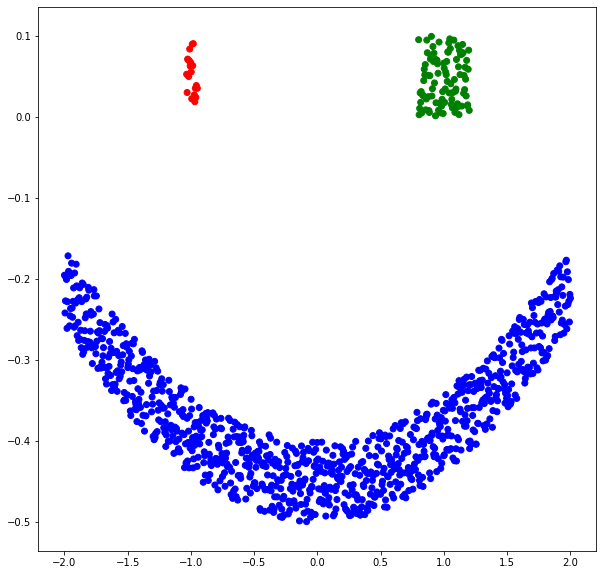

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = plt.scatter(x=df_saved["x"], y=df_saved["y"], c=df_saved["color"])

12. Add above plot to repository (as separate png file or as notebook cell output).

In [29]:
fig.savefig("plot.png", bbox_inches='tight')